# Data Analysis 
# Linear Regression 2

In this lecture (a continuation of the previous one), we'll discuss:
4. overfitting, model generalizability, the bias-variance tradeoff and cross-validation
5. regularization

Recommended reading:
* G. James, D. Witten, T. Hastie, and R. Tibshirani, An Introduction to Statistical Learning, Ch. 5.1, 6.1, 6.2 [digital version available here](https://www.statlearning.com/)

* Sebastian Raschka: Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning (https://arxiv.org/abs/1811.12808)


In [82]:
# imports and setup

import scipy as sc
import numpy as np
from scipy.stats import norm
import seaborn as sns

import pandas as pd
import statsmodels.formula.api as sm
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [83]:
#This is a helper function to assist with creating polynomial features
from sklearn.preprocessing import PolynomialFeatures

def make_features(train_set, test_set, degrees):
    train_dict = {}
    test_dict = {}
    for d in degrees:
        traintestdict={}
        train_dict[d] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        test_dict[d] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
    return train_dict, test_dict

# 4. Cross-validation

**Cross-validation** is a general method for assessing how the results of a predictive model (regression, classification,...) will *generalize* to an independent data set. In regression, cross-validation is a method for assessing how well the regression model will predict the dependent value for points that weren't used to *train* the model. 

The idea of the method is simple: 
1. Split the dataset into two groups: the training dataset and the testing dataset. 
+ Train a variety of models on the training dataset. 
+ Check the accuracy of each model on the testing dataset. 
+ By comparing these accuracies, determine which model is best.

Let's see this concept for the relationship between mpg and horsepower in the Auto dataset. We'll use the `scikit-learn` package for the cross validation analysis instead of `statsmodels`, because it is much easier to do cross validation there. 

In [84]:
auto = pd.read_csv('Auto.csv') #load data

# one of the horsepowers is '?', so we just remove it and then map the remaining strings to integers
auto = auto[auto.horsepower != '?']
auto['horsepower'] = auto['horsepower'].map(int)

auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


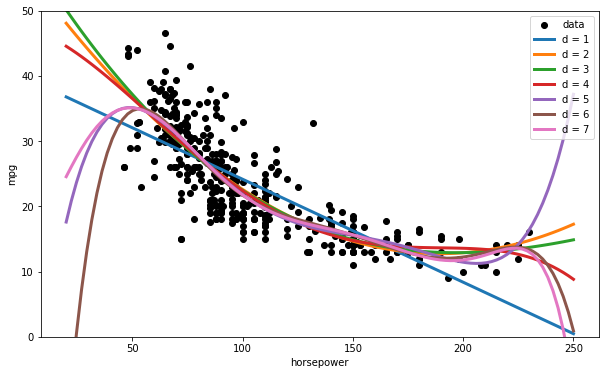

In [85]:
lr = linear_model.LinearRegression() # create a linear regression object

# with scikit-learn, we have to extract values from the pandas dataframe
for d in np.arange(2,8): 
    auto['h'+str(d)] = auto['horsepower']**d

X = auto[['horsepower','h2','h3','h4','h5','h6','h7']].values.reshape(auto['horsepower'].shape[0],7)
y = auto['mpg'].values.reshape(auto['mpg'].shape[0],1)

plt.scatter(X[:,0], y,  color='black',label='data')

# make data for plotting
xs = np.linspace(20, 250, num=100)
Xs = np.zeros([100,7])
Xs[:,0] = xs
for d in np.arange(1,7): 
    Xs[:,d] = xs**(d+1)
    
for d in np.arange(1,8):     
    lr.fit(X=X[:,:d], y=y)
    plt.plot(xs, lr.predict(X=Xs[:,:d]), linewidth=3, label = "d = " + str(d) )

plt.legend(loc='upper right')
plt.xlabel('horsepower'); plt.ylabel('mpg')
plt.ylim((0,50))
plt.show()

### 4.1 Cross validation using scikit-learn 

- In scikit-learn, you can use the [*train_test_split*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split the dataset into a training dataset and a test dataset. This split is supposed to be random (pay attention to which method you are using and how it does the splitting). Obviously, we might get a bad random split (if we are unlucky). There are ways to control for that (e.g. through K-fold cross validation see below).
+ The *score* function returns the coefficient of determination, $R^2$, of the prediction.

In the following code, I've split the data in an unusual way - taking the test set to be 90% - to illustrate the point more clearly. Typically, we might make the training set to be 70-90% of the dataset. 

(39, 7) (39, 1)
(353, 7) (353, 1)
d= 1 , train:  0.6508117557688201  test:  0.5861089204353647
d= 2 , train:  0.7788726103432309  test:  0.6773426966876412
d= 3 , train:  0.7809007867736247  test:  0.6730819069807141
d= 4 , train:  0.7818275548491538  test:  0.6715071420669175
d= 5 , train:  0.7849846290954009  test:  0.6522245738926651
d= 6 , train:  0.7875536940355249  test:  0.6029746322490954
d= 7 , train:  0.7892321612134761  test:  0.6118949326292742


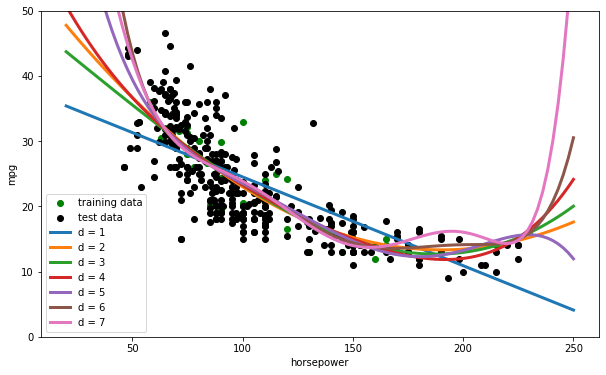

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

plt.scatter(X_train[:,0], y_train,  color='green',label='training data')
plt.scatter(X_test[:,0], y_test,  color='black',label='test data')
err_train=[]
err_val=[]

for d in np.arange(1,8):     
    lr.fit(X=X_train[:,:d], y=y_train)
    errval = mean_squared_error(y_test, lr.predict(X_test[:,:d]))
    errtrain = mean_squared_error(y_train, lr.predict(X_train[:,:d]))
    err_train.append(errtrain)
    err_val.append(errval)
    print('d=', d, ', train: ', lr.score(X_train[:,:d], y_train), ' test: ', lr.score(X_test[:,:d], y_test))
#    print('d=', d, ', train: ', lr.score(X_train[:,:d], y_train), ' test: ', lr.score(X_test[:,:d], y_test))
    plt.plot(xs, lr.predict(X=Xs[:,:d]), linewidth=3, label = "d = " + str(d) )

plt.legend()
plt.xlabel('horsepower'); plt.ylabel('mpg')
plt.ylim((0,50))
plt.show()


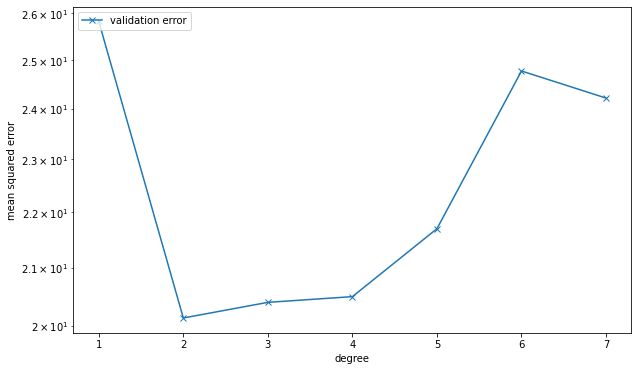

In [87]:
#plt.plot(np.arange(1,8), err_train, marker='o', label='training error')
plt.plot(np.arange(1,8), err_val, marker='x', label='validation error')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")

### 4.2 K-Fold cross-validation in Python 

Let us now do 5-fold cross-validation on our  data set.

- Similarly as before, we could use the [*train_test_split*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split the dataset accordingly. However, python offers more functions to do this.
-  We increase the complexity from degree 0 to degree 20. In each case we take the old training set, split in 5 ways into 5 folds, train on 4 folds, and calculate the validation error on the remaining one. We then average the errors over the five folds to get a cross-validation error for that $d$. 

We will use `KFold` from `scikit-learn`.

In [88]:
X = auto['horsepower'].values.reshape(auto['horsepower'].shape[0],1)
y = auto['mpg'].values.reshape(auto['mpg'].shape[0],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

from sklearn.model_selection import KFold
n_folds=5

kfold = KFold(n_folds)
list(kfold.split(range(79)))

(313, 1) (313, 1)
(79, 1) (79, 1)


[(array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
         33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
         50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
         67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 32,
         33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
         50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
         67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]),
  array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 48, 49,
         50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
         67, 68, 69, 70, 71, 72, 73, 

What is wrong with the above? Why we must execute KFold with the line below?

In [89]:
kfold = KFold(n_folds, shuffle=True)
list(kfold.split(range(79)))

[(array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         19, 20, 21, 22, 24, 25, 26, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38,
         42, 43, 44, 47, 48, 51, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66,
         67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]),
  array([ 7, 18, 23, 27, 30, 39, 40, 41, 45, 46, 49, 50, 52, 53, 54, 59])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18,
         20, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40,
         41, 42, 43, 44, 45, 46, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60,
         61, 63, 64, 65, 67, 68, 71, 72, 73, 74, 76, 78]),
  array([12, 13, 19, 21, 25, 28, 35, 47, 48, 51, 62, 66, 69, 70, 75, 77])),
 (array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 18, 19, 21,
         22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 39, 40, 41, 42,
         43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 59, 60, 61, 62, 63,
         64, 66, 67, 68, 69, 70, 72, 

In [90]:
n_folds=5
d=20
degrees=range(d+1)
train_errors = np.zeros((d+1,5))
valid_errors = np.zeros((d+1,5))

In [91]:
fold = 0
for train, valid in KFold(n_folds, shuffle=True).split(range(79)): # split data into train/test groups, 5 times
    train_dict, valid_dict = make_features(X_train[train], X_train[valid], degrees)
    for d in degrees:
        model = linear_model.LinearRegression()
        model.fit(train_dict[d], y_train[train]) # fit
        train_errors[d, fold] = mean_squared_error(y_train[train], model.predict(train_dict[d])) # evaluate score function on held-out data
        valid_errors[d, fold] = mean_squared_error(y_train[valid], model.predict(valid_dict[d])) # evaluate score function on held-out data
    fold += 1

We average the MSEs over the folds

In [92]:
mean_train_errors = train_errors.mean(axis=1)
mean_valid_errors = valid_errors.mean(axis=1)
std_train_errors = train_errors.std(axis=1)
std_valid_errors = valid_errors.std(axis=1)

We find the degree that minimizes the `cross-validation` error, and just like before, refit the model on the entire training set

2


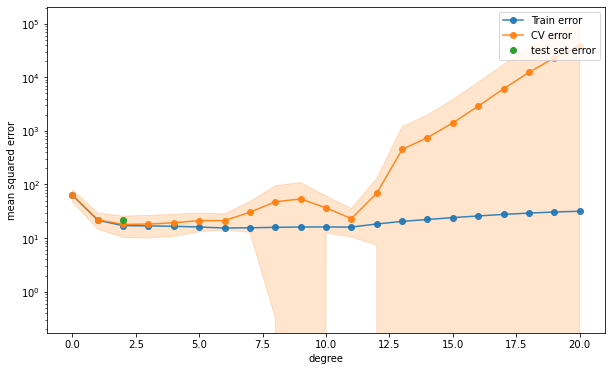

In [93]:
mindeg = np.argmin(mean_valid_errors)
print(mindeg)
post_cv_train_dict, test_dict=make_features(X_train, X_test, degrees)

#fit on whole training set now.
model = linear_model.LinearRegression()
model.fit(post_cv_train_dict[mindeg], y_train) # fit
pred = model.predict(test_dict[mindeg])
err = mean_squared_error(pred, y_test)
errtr=mean_squared_error(y_train, model.predict(post_cv_train_dict[mindeg]))
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
#plt.errorbar(degrees, [r[0] for r in results], yerr=[r[3] for r in results], marker='o', label='CV error', alpha=0.5)
plt.plot(degrees, mean_train_errors, marker='o', label='Train error', alpha=0.9)
plt.plot(degrees, mean_valid_errors, marker='o', label='CV error', alpha=0.9)


plt.fill_between(degrees, mean_valid_errors-std_valid_errors, mean_valid_errors+std_valid_errors, color=c1, alpha=0.2)


plt.plot([mindeg], [err], 'o',  label='test set error')

plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper right')
plt.yscale("log")

We see that the cross-validation error minimizes at a low degree, and then increases. Because we have so few data points the spread in fold errors increases as well.

# 5. Controling for overfitting: Regularization

The subset selection methods use least squares to fit a linear model that contains a subset of the predictors. As an alternative, we can fit a model containing all predictors using a technique that constrains or regularizes the coefficient estimates, or or equivalently, that shrinks the  coefficient estimates towards zero. Think for a moment, why we want to squeeze them to zero?

In the ordinary least squares problem we minimize the loss function:

\begin{equation}
L(\mathbf{\beta}) = \frac{1}{n} \sum_{i = 1}^n (y_i - \mathbf{\beta}^T \mathbf{x}_i)^2,
\end{equation}

to determine regression coefficients $\mathbf{\beta}$.  Here $y_i$ is the response variable for observation $i$, and $\mathbf{x}_i$ is a vector from the predictor matrix  corresponding to observation $i$.


The general idea behind regularization is to penalize the loss function to account for possibly very large values of the coefficients $\mathbf \beta$.  The  aforementioned optimization problem is then adjusted accordingly.  Instead of minimizing $L(\mathbf{\beta})$, we minimize the regularized loss function

\begin{equation}
L_{\mathrm{reg}}(\mathbf{\beta}) = L(\mathbf{\beta}) + \lambda R(\mathbf{\beta}),
\end{equation}

where $R(\mathbf{\beta})$ is a penalty function and $\lambda$ is a scalar that weighs the relative importance of this penalty.  In this course we will explore two regularized regression models, Ridge ($L2$) and LASSO ($L1$). In ridge regression, the penalty function is the sum of the squares of the parameters, giving the regularized loss function

\begin{equation}
L_{\mathrm{Ridge}}(\mathbf{\beta}) = \frac{1}{n} \sum_{i = 1}^n (y_i - \mathbf{\beta}^T \mathbf{x}_i)^2 + \lambda \sum_{j = 1}^d \beta_j^2.
\end{equation}

In LASSO regression the penalty function is the sum of the magnitudes of the parameters, leading to

\begin{equation}
L_{\mathrm{LASSO}}(\mathbf{\beta}) = \frac{1}{n} \sum_{i = 1}^n (y_i - \mathbf{\beta}^T \mathbf{x}_i)^2 + \lambda \sum_{j = 1}^d |\beta_j|.
\end{equation}

We will show how these optimization problems can be solved with `sklearn` to determine the model parameters $\mathbf \beta$.  We will also show how to choose $\lambda$ appropriately via cross-validation.

Going back to the problem of selecting a polynomial degree, then we have focused on finding the polynomial with the right degree of complexity $d=*$ given the data that we have.

When we **regularize** we smooth or restrict the choices of the kinds of (up to) 5th order polynomials that we allow in our fits. That is, if we want to fit with a 5th order polynomial, ok, lets fit with it, but lets reduce the size of, or limit the functions that we allow. Note that sklearn uses the notation $\alpha$ instead of $\lambda$.

## 5.1 Regularization of our model with Cross-Validation

The addition of a penalty term to the risk or error causes us to choose a smaller subset of the entire set of complex $\cal{H}_{5}$ polynomials. This is shown in the diagram below where the balance between bias and variance occurs at some subset $S_*$ of the set of 5th order polynomials indexed by $\alpha_*$.

Some notes:
1. there is an error on the diagram, the 13 there should actually be a 5).
2. in textbooks we commonly use $\lambda$ as the symbol for regularization parameter but in scikit-learn that is $\alpha$.

![m:caption](complexity-error-reg.png)

Lets see what some of the $\alpha$s do. The diagram below trains on the entire training set, for given values of $\alpha$, minimizing the penalty-term-added training error.

**Note that here we are doing the note so good thing of exhausting the test set for demonstration purposes**

In [23]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

In [24]:
df = pd.read_csv('Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [25]:
df.head()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    bool 
 1   League_N     263 non-null    bool 
 2   Division_E   263 non-null    bool 
 3   Division_W   263 non-null    bool 
 4   NewLeague_A  263 non-null    bool 
 5   NewLeague_N  263 non-null    bool 
dtypes: bool(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby           False      True       False        True        False   
-Alvin Davis           True     False       False        True         True   
-Andre Dawson         False      True        True       False        False   
-Andres Galarraga     False      True        True       False        False   
-Alfredo Griffin       True     False       False     

In [26]:
# Drop the columns for which we created dummy variables
dfnew = df.drop(['League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
dfnew = pd.concat([dfnew, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
dfnew.info()

dfnew.head()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  Salary       263 non-null    float64
 17  League_N     263 non-null    bool   
 18  Division_W   263 non-null    bool 

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,475.0,True,True,True
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,480.0,False,True,False
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,500.0,True,False,True
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,91.5,True,False,True
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,750.0,False,True,False


Let us define a helper function to help us do the train/test splits. I also have the option of whether I want a further split to validation set.

In [27]:
def train_test_split(df, n_samples=df.shape[0], validation=False):
    if validation:
        sample = df.sample(n=n_samples)

        msk = np.random.rand(len(sample)) < 0.8
        non_test = sample[msk]
        test = sample[~msk]
        
        msk = np.random.rand(len(non_test)) < 0.7
        train = non_test[msk]
        validation = non_test[~msk]
        
        return train, validation, test
    
    else:
        sample = df.sample(n=n_samples)

        msk = np.random.rand(len(sample)) < 0.8
        train = sample[msk]
        test = sample[~msk]
        
        return train, test

In [28]:
cols = ['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'League_N',
 'Division_W',
 'NewLeague_N']
all_predictors = cols


train, validation, test = train_test_split(dfnew, validation=True)

y_train = train['Salary'].values
y_val = validation['Salary'].values
y_test = test['Salary'].values

X_train = train[all_predictors].values
X_val = validation[all_predictors].values
X_test = test[all_predictors].values

#for simplicity, let's keep this
X_non_test = np.vstack((X_train, X_val))
y_non_test = np.hstack((y_train, y_val))

For demonstrating the same results, let's use the following split:

In [29]:
X_non_test = pd.read_csv('Hitters_X_train.csv', index_col=0)
y_non_test = pd.read_csv('Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Hitters_y_test.csv', index_col=0)

### a) Ridge Regression

In [30]:
ridge_regression = Ridge(alpha=100, fit_intercept=True)
ridge_regression.fit(X_non_test, y_non_test)

print('Ridge regression model:\n {} + {}^T . x'.format(ridge_regression.intercept_, ridge_regression.coef_))

Ridge regression model:
 [269.56963309] + [[-2.59320290e+00  7.95365166e+00  1.01526827e+01 -8.88190364e+00
   3.66163617e+00  9.39732252e+00 -1.96711661e+01 -2.18202541e-01
  -1.34108398e-02 -1.33413633e+00  3.43576846e+00 -4.07114870e-02
  -1.07782594e+00  1.18354515e+01 -2.17803076e+01  3.56948780e-01
   3.69340769e-01  1.81284848e-01  8.99839522e+00]]^T . x


In [31]:
pd.Series(ridge_regression.coef_.flatten(), index=cols)

AtBat          -2.593203
Hits            7.953652
HmRun          10.152683
Runs           -8.881904
RBI             3.661636
Walks           9.397323
Years         -19.671166
CAtBat         -0.218203
CHits          -0.013411
CHmRun         -1.334136
CRuns           3.435768
CRBI           -0.040711
CWalks         -1.077826
PutOuts        11.835452
Assists       -21.780308
Errors          0.356949
League_N        0.369341
Division_W      0.181285
NewLeague_N     8.998395
dtype: float64

In [32]:
print('Train R^2: {}, test R^2: {}'.format(ridge_regression.score(X_non_test,y_non_test),
                                           ridge_regression.score(X_test, y_test)))

Train R^2: 0.503801792085007, test R^2: 0.3683455367427242


### Why we need to standardize the predictors?

The standard least squares coefficient estimates are scale equivariant: multiplying a predictor value $X_j$ by a constant $c$ simply leads to a scaling of the least squares coefficient estimates by a factor of $1/c$. In other words, regardless of how the $j$-th predictor is scaled, the product $X_j\cdot \beta_j$ will remain the same.

In contrast, the ridge regression coefficient estimates can change substantially when multiplying a given predictor by  a constant, due to the sum of squared coefficients term in  the penalty part of the ridge regression objective  function.

Therefore, it is best to apply ridge regression after standardizing the predictors, using the formula

$$
\tilde x_{ij} = \frac{x_{ij}}{\sqrt{\frac{1}{n}\sum_{i=1}^n (x_{ij}-\bar x_j)^2}}
$$


In [33]:
ridge_std = Ridge(alpha=10, fit_intercept=True)
ridge_std.fit(scale(X_non_test), y_non_test)

Ridge(alpha=10)

In [34]:
print('Ridge regression model:\n {} + {}^T . x'.format(ridge_std.intercept_, ridge_std.coef_))
pd.Series(ridge_std.coef_.flatten(), index=cols)

Ridge regression model:
 [547.98473282] + [[-85.01535108  60.202096    39.86634368  -9.567415    27.89250628
  114.14532939 -74.73682258  13.48890883  83.61520559 -10.13565567
  133.99839434   8.27450231 -14.60428032  21.827649   -70.8502637
   87.44770204  22.58795954 -11.1513239    6.28523586]]^T . x


AtBat          -85.015351
Hits            60.202096
HmRun           39.866344
Runs            -9.567415
RBI             27.892506
Walks          114.145329
Years          -74.736823
CAtBat          13.488909
CHits           83.615206
CHmRun         -10.135656
CRuns          133.998394
CRBI             8.274502
CWalks         -14.604280
PutOuts         21.827649
Assists        -70.850264
Errors          87.447702
League_N        22.587960
Division_W     -11.151324
NewLeague_N      6.285236
dtype: float64

In [35]:
print('Train R^2: {}, test R^2: {}'.format(ridge_std.score(scale(X_non_test),y_non_test),
                                           ridge_std.score(scale(X_test), y_test)))

Train R^2: 0.4507078936911417, test R^2: 0.4890002289423785


### b) LASSO Regression

In [36]:
#not increasing the # of iterations, might give you a convergence warning
lasso_regression = Lasso(alpha=1, fit_intercept=True, max_iter=10000)
lasso_regression.fit(X_non_test, y_non_test)

print('Lasso regression model:\n {} + {}^T . x'.format(lasso_regression.intercept_, lasso_regression.coef_))

Lasso regression model:
 [298.61270238] + [-2.53744000e+00  8.30160619e+00  1.14942441e+01 -9.05304267e+00
  2.52731096e+00  9.24291902e+00 -2.27572666e+01 -1.84248417e-01
 -1.01903813e-01 -1.32506897e+00  3.32380019e+00  6.26335672e-02
 -1.07562505e+00  5.47136396e+01 -9.42506662e+01  3.42268551e-01
  3.42132008e-01 -5.38374455e-01  0.00000000e+00]^T . x


In [37]:
print('Train R^2: {}, test R^2: {}'.format(lasso_regression.score(X_non_test, y_non_test), 
                                           lasso_regression.score(X_test, y_test)))

Train R^2: 0.5117894312287234, test R^2: 0.40300507389768514


## 5.2 The Effect of the Regularization Parameter

Let's see in more detail what is the effect of regularization. We will vary the regularization parameter from $10^{-5}$ i.e. $0.00001$ till $10^9$ i.e. $1000000000$.

In [38]:
reg_params = np.hstack((10.**np.arange(-5, 0), 10**np.arange(0, 10) + 0.01))

### a) Ridge Regression

In [39]:
train_R_sq = []
test_R_sq = []
coefs = []

for reg in reg_params:
    ridge_regression1 = Ridge(alpha=reg, fit_intercept=True)
    ridge_regression1.fit(scale(X_non_test), y_non_test)
    coefs.append(ridge_regression1.coef_)

    
    train_R_sq.append(ridge_regression1.score(scale(X_non_test),y_non_test))
    test_R_sq.append(ridge_regression1.score(scale(X_test), y_test))

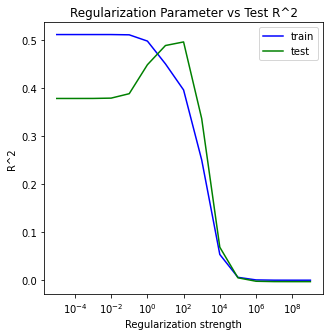

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, train_R_sq, color='blue', label='train')
ax.plot(reg_params, test_R_sq, color='green', label='test')

ax.set_xscale('log')
ax.set_title('Regularization Parameter vs Test R^2')
ax.set_xlabel('Regularization strength')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

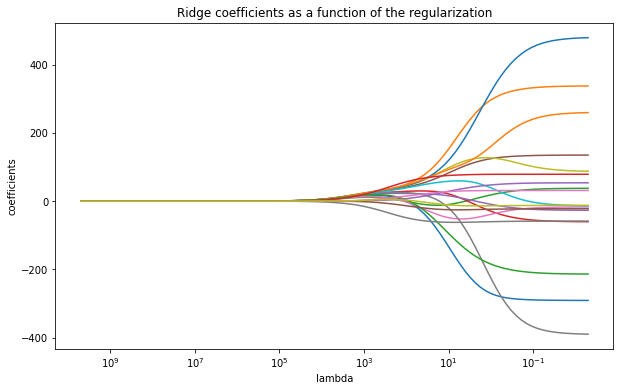

In [41]:
y = df.Salary
# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('coefficients')
plt.title('Ridge coefficients as a function of the regularization');

### b) LASSO Regression

In [42]:
train_R_sq = []
test_R_sq = []

for reg in reg_params:
    lasso_regression = Lasso(alpha=reg, max_iter=100000, fit_intercept=True)
    lasso_regression.fit(X_non_test, y_non_test)
    
    train_R_sq.append(lasso_regression.score(X_non_test, y_non_test))
    test_R_sq.append(lasso_regression.score(X_test, y_test))

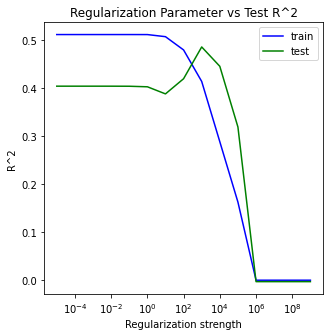

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, train_R_sq, color='blue', label='train')
ax.plot(reg_params, test_R_sq, color='green', label='test')

ax.set_xscale('log')
ax.set_title('Regularization Parameter vs Test R^2')
ax.set_xlabel('Regularization strength')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

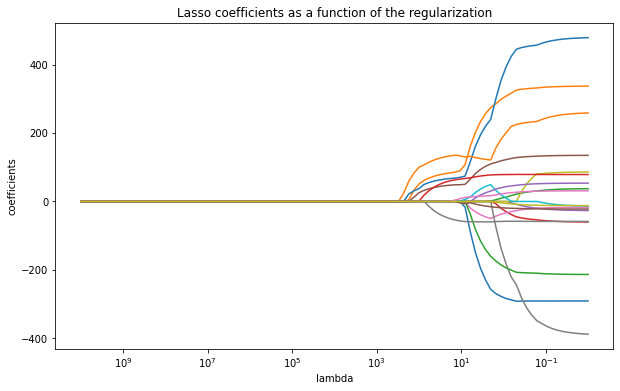

In [44]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('coefficients')
plt.title('Lasso coefficients as a function of the regularization');

## 5.3 Cross Validation: Selecting the Regularization Parameter (check it at home -- it will come for the clinic as well)

How do I select the regularization parameter? Simply, with cross-validation. In this case, we also use the MSE (mean squared error) as a performance metric. This just puts together what we discussed before (regularization + cross-validation).

In [45]:
X_non_test = np.vstack((X_train, X_val))
y_non_test = np.hstack((y_train, y_val))

kf = KFold(n_splits=10)

x_val_scores = []
mse_val = []

for reg in reg_params:
    ridge_regression = Ridge(alpha=reg, fit_intercept=True)
    
    validation_R_sqs = []
    mses = []
    for train_index, val_index in kf.split(X_non_test):
        X_train, X_val = X_non_test[train_index], X_non_test[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        
        ridge_regression.fit(scale(X_train), y_train)
        validation_R_sqs.append(ridge_regression.score(scale(X_val), y_val))
        pred = ridge_regression.predict(scale(X_val))
        mses.append(mean_squared_error(y_val, pred))

        
    x_val_scores.append(np.mean(validation_R_sqs))
    mse_val.append(np.mean(mses))

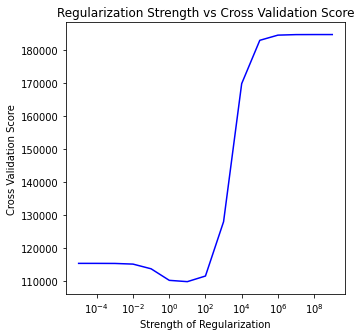

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, mse_val, color='blue')

ax.set_xscale('log')
ax.set_title('Regularization Strength vs Cross Validation Score')
ax.set_xlabel('Strength of Regularization')
ax.set_ylabel('Cross Validation Score')

plt.show()

In [47]:
best_alpha = reg_params[np.argmin(mse_val)]

ridge_regression = Ridge(alpha=best_alpha, fit_intercept=True)
ridge_regression.fit(scale(X_non_test), y_non_test)
pred = ridge_regression.predict(scale(X_test))
mse_final = mean_squared_error(y_test, pred)
#test_R_sq = (ridge_regression.score(scale(X_test), y_test))

print('best regularization param is:', best_alpha)
print('the MSE (test set) for ridge regression with alpha = {} is: {}'.format(best_alpha, mse_final))

best regularization param is: 10.01
the MSE (test set) for ridge regression with alpha = 10.01 is: 104984.46479905066


In [48]:
pd.Series(ridge.coef_.flatten(), index=X.columns)

AtBat         -291.006253
Hits           337.528334
HmRun           37.673623
Runs           -60.293410
RBI            -26.829269
Walks          135.000609
Years          -16.872957
CAtBat        -389.910351
CHits           87.649745
CHmRun         -13.534996
CRuns          479.163318
CRBI           259.529823
CWalks        -213.633676
PutOuts         78.761373
Assists         53.694656
Errors         -22.176895
League_N        31.251786
Division_W     -58.429002
NewLeague_N    -12.367081
dtype: float64

### Alternative approaches: Use `RidgeCV` and `LassoCV`

(check the documentation carefully before you apply them)

In [49]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+0...
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
        scoring='neg_mean_squared_error')

In [50]:
ridgecv.alpha_

115.5064850041579

In [51]:
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge.predict(scale(X_test)))

97975.71293495214

In [52]:
pd.Series(ridge.coef_.flatten(), index=X.columns)

AtBat           6.405298
Hits           38.861135
HmRun           2.174441
Runs           20.338332
RBI            19.514125
Walks          47.650978
Years           9.515574
CAtBat         24.935267
CHits          34.985439
CHmRun         25.311828
CRuns          34.822102
CRBI           34.336511
CWalks         20.840725
PutOuts        47.779138
Assists        18.067147
Errors        -10.438062
League_N       17.189388
Division_W    -46.014906
NewLeague_N     5.318294
dtype: float64

In [53]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_non_test), y_non_test)

LassoCV(cv=10, max_iter=10000)

In [54]:
lassocv.alpha_

2.2334090110982663

In [55]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

107093.44315135703

In [56]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat         -317.049328
Hits           345.350619
HmRun           10.007124
Runs           -47.862803
RBI             23.228576
Walks          120.433304
Years          -26.185122
CAtBat          -0.000000
CHits            0.000000
CHmRun          42.488208
CRuns          205.211473
CRBI            77.481839
CWalks        -115.907436
PutOuts         81.112675
Assists         74.649976
Errors         -35.447280
League_N        27.072626
Division_W     -67.888571
NewLeague_N     -0.000000
dtype: float64

## Appendix

## Step-wise selection

One straightforward way to think about how to pick among different predictors (variables) in the model would be to try to check *all* combinations between *all* predictors and how much they affect performance. That is called "best subset selection". For computational reasons, best subset selection cannot be applied to datasets with a large number of predictors (why?).

Step-wise selection can then be a viable alternative. We have two options:

* forward selection: we start with one predictor, find the best model with only one predictor (based on a performance metric), move to models with two predictors (by keeping the one predictor fixed) etc.

* backward selection: opposite as above, we start with a model with all predictors and reduce them one by one.

It is not guaranteed to find the best possible model out of all $2^p$ models containing subsets of all predictors (why?).

In [67]:
df = pd.read_csv('Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [68]:
df.head()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    bool 
 1   League_N     263 non-null    bool 
 2   Division_E   263 non-null    bool 
 3   Division_W   263 non-null    bool 
 4   NewLeague_A  263 non-null    bool 
 5   NewLeague_N  263 non-null    bool 
dtypes: bool(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby           False      True       False        True        False   
-Alvin Davis           True     False       False        True         True   
-Andre Dawson         False      True        True       False        False   
-Andres Galarraga     False      True        True       False        False   
-Alfredo Griffin       True     False       False     

In [69]:
# Drop the columns for which we created dummy variables
dfnew = df.drop(['League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
dfnew = pd.concat([dfnew, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  Salary       263 non-null    float64
 17  League_N     263 non-null    bool   
 18  Division_W   263 non-null    bool 

In [70]:
X_train = pd.read_csv('Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Hitters_y_test.csv', index_col=0)

In [71]:
cols = ['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'League_N',
 'Division_W',
 'NewLeague_N']

train, validation, test = train_test_split(dfnew, validation=True)

y_train = train['Salary'].values
y_val = validation['Salary'].values
y_test = test['Salary'].values

regression_model = LinearRegression(fit_intercept=True)

### 1. Forward Selection

In [72]:
#all_predictors = credit.columns.tolist()
all_predictors = cols

predictors = [([], 0)]

regression_model = LinearRegression(fit_intercept=True)

R_sq_fwd = []

for k in range(1, len(all_predictors)):
    best_k_minus_1 = predictors[-1][0]

    new_predictors = list(set(all_predictors) - set(best_k_minus_1))
    validation_R_sqs = []

    for predictor in new_predictors:

        k_predictors = best_k_minus_1 + [predictor]
        
        X_train = train[k_predictors].values
        X_val = validation[k_predictors].values
        
        if k == 1:
            X_train = X_train.reshape((len(X_train), 1))
            
        regression_model.fit(X_train, y_train)
        validation_R_sqs.append(regression_model.score(X_val, y_val))
    
    best_k = best_k_minus_1 + [new_predictors[np.argmax(validation_R_sqs)]]
    R_sq_fwd.append(np.max(validation_R_sqs))
    predictors.append((best_k, np.max(validation_R_sqs)))


X_train = train[all_predictors].values
X_val = validation[all_predictors].values  
regression_model.fit(X_train, y_train)

predictors.append((all_predictors, regression_model.score(X_val, y_val)))

In [73]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[-1]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  

regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\nvalidation R^2: {}\ntest R^2: {}'.format(best_predictor_set[0], best_predictor_set[1], regression_model.score(X_test, y_test)))

best predictor set: ['CRuns', 'Walks', 'Hits', 'AtBat', 'HmRun', 'Runs', 'Years', 'Assists', 'Errors']
validation R^2: 0.6269654827388565
test R^2: 0.574453119591728


In [74]:
predictors

[([], 0),
 (['CRuns'], 0.3811618453664667),
 (['CRuns', 'Walks'], 0.5083924726556165),
 (['CRuns', 'Walks', 'Hits'], 0.528241041877517),
 (['CRuns', 'Walks', 'Hits', 'AtBat'], 0.603529745416488),
 (['CRuns', 'Walks', 'Hits', 'AtBat', 'HmRun'], 0.6159437325055046),
 (['CRuns', 'Walks', 'Hits', 'AtBat', 'HmRun', 'Runs'], 0.6179479607786464),
 (['CRuns', 'Walks', 'Hits', 'AtBat', 'HmRun', 'Runs', 'Years'],
  0.6232518383802639),
 (['CRuns', 'Walks', 'Hits', 'AtBat', 'HmRun', 'Runs', 'Years', 'Assists'],
  0.6251061299380338),
 (['CRuns',
   'Walks',
   'Hits',
   'AtBat',
   'HmRun',
   'Runs',
   'Years',
   'Assists',
   'Errors'],
  0.6269654827388565),
 (['CRuns',
   'Walks',
   'Hits',
   'AtBat',
   'HmRun',
   'Runs',
   'Years',
   'Assists',
   'Errors',
   'CHits'],
  0.626847588154317),
 (['CRuns',
   'Walks',
   'Hits',
   'AtBat',
   'HmRun',
   'Runs',
   'Years',
   'Assists',
   'Errors',
   'CHits',
   'CAtBat'],
  0.6239085867331469),
 (['CRuns',
   'Walks',
   'Hits',
 

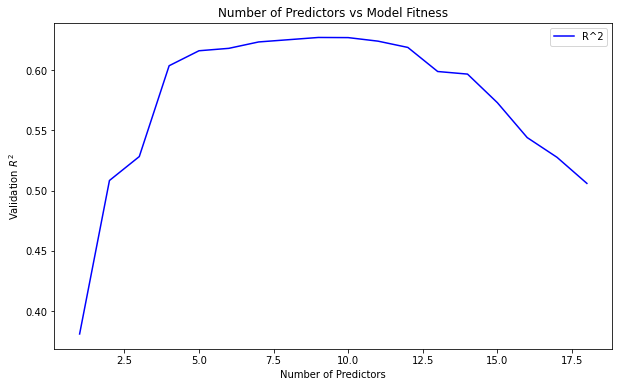

In [75]:
#a very ugly plot, needs improvement
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(range(1, len(predictors)-1 ), R_sq_fwd, color='blue', label='R^2')

ax.set_title('Number of Predictors vs Model Fitness')
ax.set_xlabel('Number of Predictors')
ax.set_ylabel('Validation $R^2$')
ax.legend(loc='best')

plt.show()

### 2. Backwards Selection

Similar processes can be applied to the backward process, i.e. start with all predictors and remove one at each step. Let's see the same process, but introduce another metric here, AIC.

The Akaike Information Criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data. The AIC criterion is defined for a large class of models fit by maximum likelihood.

$$AIC = -2 \cdot logL +2 \cdot d$$

where $L$ is the maximized value of the likelihood function for the estimated model and $d$ is the total number of parameters (here is the number of predictors).

In the case of  the linear model with Gaussian errors, maximum likelihood and least squares are the same thing. More specifically for the linear model: $ -2 \cdot logL = \frac{RSS}{\sigma^2} $. Obviously, I need to choose the model with the smallest $AIC$ value.

In [49]:
from statsmodels.tools import add_constant
import statsmodels.api as sm1

def get_aic(X_train, y_train):
    X_train = add_constant(X_train)
    model = sm1.OLS(y_train, X_train).fit()
    return model.aic

X_train = train[all_predictors].values
predictors = [(all_predictors, get_aic(X_train, y_train))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    aics = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = train[k_minus_1].values

        aics.append(get_aic(X_train, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(aics)]]))
    predictors.append((best_k_minus_1, np.min(aics)))

In [50]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[0]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  
regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\nAIC: {}\ntest R^2: {}'.format(best_predictor_set[0], best_predictor_set[1], regression_model.score(X_test, y_test)))

best predictor set: ['Assists', 'AtBat', 'Walks', 'CRuns', 'League_N', 'CWalks', 'Division_W', 'Hits', 'PutOuts', 'Years', 'CRBI', 'Runs']
AIC: 2087.5493967156344
test R^2: 0.5463905292129578


# 6. Extensions of the linear model

The linear model can be generalized into many different variations:

* Classification problems: Logistic regression, etc.

* Non-linearity: splines, generalized additive models, etc.

* Interactions: Tree-based methods (bagging, boosting, etc.)

* Regularized fitting: We covered this already!